# Uplift-modelling

In [1]:
from sklearn.model_selection import train_test_split
from sklift.datasets import fetch_x5
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=np.VisibleDeprecationWarning)


# 1. Working with data

## 1.1. Loading data

We are going to work with X5 dataset.

In [2]:
dataset = fetch_x5()

## 1.2. Understanding content of data

In [3]:
dataset.feature_names

{'train_features': ['client_id', 'treatment_flg', 'target'],
 'clients_features': ['client_id',
  'first_issue_date',
  'first_redeem_date',
  'age',
  'gender'],
 'purchases_features': ['client_id',
  'transaction_id',
  'transaction_datetime',
  'regular_points_received',
  'express_points_received',
  'regular_points_spent',
  'express_points_spent',
  'purchase_sum',
  'store_id',
  'product_id',
  'product_quantity',
  'trn_sum_from_iss',
  'trn_sum_from_red']}

`train features`:
- `client_id` - client ID
- `treatment_flg` - treatment flag: 
    - `0` - no communication, 
    - `1` - with communication
- `target` - flag of target action: 
    - `0` - no action, 
    - `1` - action

`clients_features`:
- `client_id` - client ID
- `first_issue_date` - date of first card release
- `first_redeem_date` - date of first payment
- `age` - age
- `gender` - gender:
    - `F` - female
    - `M` - male
    - `U` - unknown

`purchases_features`:
- `client_id` - client ID
- `transaction_id` - transaction ID
- `regular_points_received` 
- `express_points_received`
- `regular_points_spent`
- `express_points_spent`
- `purchase_sum` - total sum of transaction
- `store_id` - store ID
- `product_id` - product ID
- `product_quantity` - quantity of product ID
- `trn_sum_from_iss` 
- `trn_sum_from_red` 

## 1.3. Feature selecting

- `client_id`
- `first_issue_time` - convert `first_issue_date` from datetime type to int: number of days past `2017-01-01 00:00:00`
- `first_redeem_time` - convert `first_redeem_date` from datetime type to int: number of days past `2017-01-01 00:00:00`
- `age`
- `gender` - "one-hot" representation

## 1.4. Feature generation
- `transaction_amount` - total number of transactions
- `transaction_sum` - total sum of transactions
- `regular_points_spent_sum` - total sum of `regular_points_spent`
- `express_points_spent_sum` - total sum of `express_points_spent`
- `ragular_points_spent_to_total` - `regular_points_spent` / `transaction_sum`
- `express_points_spent_to_total` - `express_points_spent` / `transaction_sum`
- `avg_transaction` - `transaction_sum` / `transaction_amount`

In [4]:
df_clients = dataset.data['clients'].set_index("client_id")
df_purchases =  pd.concat([dataset.data['purchases'][["client_id", "transaction_id"]].drop_duplicates().groupby(["client_id"]).count(),
                           dataset.data['purchases'][["client_id", "purchase_sum", "regular_points_spent", "express_points_spent"]].drop_duplicates().groupby(["client_id"]).sum()], 
                           axis=1)
df_train = pd.concat([dataset.data['train'], dataset.treatment , dataset.target], axis=1).set_index("client_id")
indices_test = pd.Index(set(df_clients.index) - set(df_train.index))

df_features = df_clients.copy()

df_features['first_issue_time'] = \
    ((pd.to_datetime(df_features['first_issue_date'])
     - pd.Timestamp('2017-01-01')) // pd.Timedelta('1d'))
    
df_features['first_redeem_time'] = \
    ((pd.to_datetime(df_features['first_redeem_date'])
     - pd.Timestamp('2017-01-01')) // pd.Timedelta('1d'))
    
df_features['gender_M_flg'] = pd.get_dummies(df_features['gender'])['M']
df_features['gender_F_flg'] = pd.get_dummies(df_features['gender'])['F']

df_features['transaction_amount'] = df_purchases['transaction_id']
df_features['transaction_sum'] = df_purchases['purchase_sum']
df_features['regular_points_spent_sum'] = -df_purchases['regular_points_spent']
df_features['express_points_spent_sum'] = -df_purchases['express_points_spent']

df_features['ragular_points_spent_to_total'] = df_features['regular_points_spent_sum'] / df_features['transaction_sum']
df_features['express_points_spent_to_total'] = df_features['express_points_spent_sum'] / df_features['transaction_sum']
df_features['avg_transaction'] = df_features['transaction_sum']/df_features['transaction_amount']

df_features = df_features.drop(['first_issue_date', 'first_redeem_date', 'gender'], axis=1)

indices_learn, indices_valid = train_test_split(df_train.index, test_size=0.3, random_state=42)

del df_clients
del df_purchases

pd.concat([df_features.head(), df_features.tail()], axis=0)

,age,first_issue_time,first_redeem_time,gender_M_flg,gender_F_flg,transaction_amount,transaction_sum,regular_points_spent_sum,express_points_spent_sum,ragular_points_spent_to_total,express_points_spent_to_total,avg_transaction
client_id,,,,,,,,,,,,
000012768d,45,216,368.0,0,0,4,2803.00,-0.0,-0.0,-0.000000,-0.0,700.750000
000036f903,72,99,112.0,0,1,32,9439.00,-0.0,-0.0,-0.000000,-0.0,294.968750
000048b7a6,68,713,NaN,0,1,8,3772.00,-0.0,-0.0,-0.000000,-0.0,471.500000
000073194a,60,142,327.0,0,1,17,9282.40,96.0,-0.0,0.010342,-0.0,546.023529
00007c7133,67,141,729.0,0,0,11,6719.84,240.0,-0.0,0.035715,-0.0,610.894545
fffece623e,67,497,725.0,0,0,24,6530.01,68.0,-0.0,0.010413,-0.0,272.083750
ffff3dfff8,56,669,705.0,0,1,17,7264.84,182.0,-0.0,0.025052,-0.0,427.343529
ffffaab9da,23,236,341.0,0,1,7,3791.00,6.0,-0.0,0.001583,-0.0,541.571429
ffffeb5619,62,338,NaN,0,0,7,15226.22,-0.0,-0.0,-0.000000,-0.0,2175.174286


In [5]:
X_train = df_features.loc[indices_learn, :]
y_train = df_train.loc[indices_learn, 'target']
treat_train = df_train.loc[indices_learn, 'treatment_flg']

X_val = df_features.loc[indices_valid, :]
y_val = df_train.loc[indices_valid, 'target']
treat_val =  df_train.loc[indices_valid, 'treatment_flg']

X_train_full = df_features.loc[df_train.index, :]
y_train_full = df_train.loc[:, 'target']
treat_train_full = df_train.loc[:, 'treatment_flg']

X_test = df_features.loc[indices_test, :]

del df_train

In [6]:
pd.crosstab(treat_train_full, y_train_full, normalize='index')

target,0,1
treatment_flg,,
0,0.396720,0.603280
1,0.363489,0.636511


## 1.5. Ideas!!!

### 1.5.1 Use some products as features (I don't know is it a good idea)

I guess `4009f09b04` is a plastic bag :)

In [7]:
dataset.data.purchases.product_id.value_counts().head(15)

4009f09b04    1824586
15ccaa8685     628910
bf07df54e1     414745
3e038662c0     383480
4dcf79043e     370451
f4599ca21a     330278
5cb93c9bc5     320701
4a29330c8d     293404
439498bce2     251743
343e841aaa     230927
0a46068efc     221386
dc2001d036     206469
31dcf71bbd     191268
5645789fdf     188635
113e3ace79     188625
Name: product_id, dtype: int64

<AxesSubplot: >

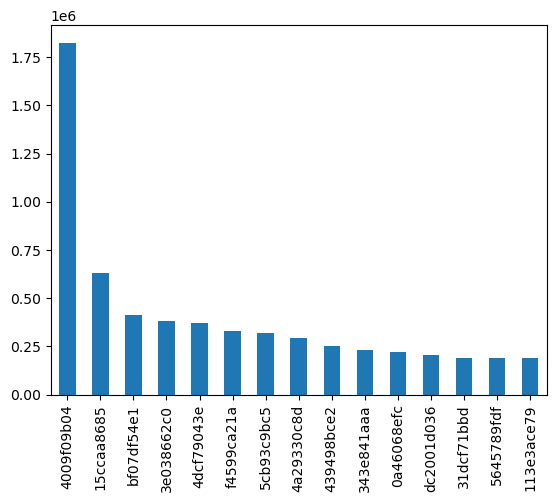

In [8]:
dataset.data.purchases.product_id.value_counts().head(15).plot.bar()

# 2. Metrics

## 2.1. uplift@k

$$uplift@k = response\_rate@k_{treat} - response\_rate@k_{control}$$
$$ response\_rate@k = mean(Y@k)$$

## 2.2. uplift percentile

1. Sort by predicted uplift value

2. We divide the sorted data into percentiles

3. In each percentile, we separately estimate the uplift as the difference between the mean values of the target variable in the test and control groups

## 2.3. uplift curve and AUC

The uplift curve is built as a function of the number of objects, on an accrual basis. At each point of the curve, you can see the uplift accumulated up to this point
$$uplift\_curve(t) = \left(\dfrac{Y_t^T}{N_t^T} - \dfrac{Y_t^C}{N_t^C}\right)(N_t^T + N_t^C) $$

# 3. Trying some models

## 3.1. S-Learner (Solo model approach)

<p align="center" width="500">
    <img src="images/SoloModel.png" alt="Solo Model" width="500"/>
</p>

Let's write it from scratch!

In [9]:
from sklearn.base import BaseEstimator
from sklift.viz import plot_uplift_by_percentile
import numpy as np

class S_Learner(BaseEstimator):
    def __init__(self, clf):
        self.clf = clf
        self.trained = False
        self.have_predictions = False
        self.treatment_proba = None
        self.control_proba = None
        self.uplift = None
        
    def fit(self, X_train, W_train, Y_train):
        assert len(X_train) == len(W_train) == len(Y_train), "Input data shoud has the same size!"
        train = pd.concat([X_train, W_train], axis=1)
        self.clf.fit(train, Y_train)
        self.trained = True
        
    def predict(self, X_test, W_test):
        assert len(X_test) == len(W_test), "Input data shoud has the same size!"
        assert self.trained, "Model is not trained yet!" 
        X_treatment = pd.concat([X_test, W_test], axis=1)
        X_control = pd.concat([X_test, W_test], axis=1)
        X_treatment[W_test.name] = 1
        X_control[W_test.name] = 0
        self.treatment_proba = self.clf.predict_proba(X_treatment)[:, 1]
        self.control_proba = self.clf.predict_proba(X_control)[:, 1]
        self.uplift = self.treatment_proba - self.control_proba
        self.have_predictions = True
        return self.uplift
    
    def plot_uplift(self, W_test, Y_test, split_size = 10):
        assert len(self.uplift) == len(Y_test) == len(W_test), f"Input data shoud has the same size as self.uplift = {len(self.uplift)}!"
        indices = np.array_split(np.argsort(self.uplift)[::-1], split_size)
        percentiles_str = [f"{i * split_size:.0f}-{(i + 1) * split_size:.0f}" for i in range(split_size)]
        treat_response = []
        control_response = []
        uplift = []
        for inds in indices:
            mask_treat = W_test.iloc[inds] == 1
            treat_response.append(np.mean(Y_test.iloc[inds][mask_treat]))
            control_response.append(np.mean(Y_test.iloc[inds][~mask_treat]))
            uplift.append(np.mean(Y_test.iloc[inds][mask_treat]) - np.mean(Y_test.iloc[inds][~mask_treat]))
        
        #plt.figure(figsize=(8, 6))
        plt.title(f"Uplift by percentile\n Avg uplift={np.array(uplift).mean():.3f}")
        plt.plot(treat_response, "-+", color="blue", label="Treatment response rate")
        plt.plot(control_response, "-+", color="green", label="Control response rate")
        plt.plot(uplift, "-+", color="red", label="Uplift")
        plt.plot(np.zeros(split_size), color="grey")
        plt.xticks(ticks=range(10),labels=percentiles_str, rotation=45)
        plt.xlabel("Percentile")
        plt.legend()

,feature_name,feature_score
0,transaction_amount,41.685005
1,first_redeem_time,28.991859
2,first_issue_time,8.127917
3,age,4.928130
4,transaction_sum,2.920686
5,ragular_points_spent_to_total,2.798601
6,avg_transaction,2.418586
7,treatment_flg,2.127666
8,regular_points_spent_sum,1.674528
9,express_points_spent_to_total,1.658945


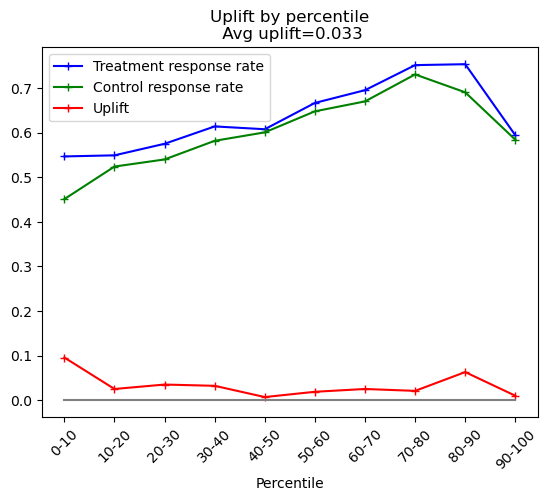

In [10]:
from catboost import CatBoostClassifier

cat_config = {"iterations": 100, "thread_count": 2, "random_state": 42, "silent": True}

s_learner_model = S_Learner(CatBoostClassifier(**cat_config))
s_learner_model.fit(X_train, treat_train, y_train)

uplift = s_learner_model.predict(X_val, treat_val)

s_learner_model.plot_uplift(treat_val, y_val)

feature_importance = pd.DataFrame({
    'feature_name': s_learner_model.clf.feature_names_,
    'feature_score': s_learner_model.clf.feature_importances_
}).sort_values('feature_score', ascending=False).reset_index(drop=True)

feature_importance

Let's check it with `sklift.models.SoloModel`:

,feature_name,feature_score
0,transaction_amount,41.685005
1,first_redeem_time,28.991859
2,first_issue_time,8.127917
3,age,4.928130
4,transaction_sum,2.920686
5,ragular_points_spent_to_total,2.798601
6,avg_transaction,2.418586
7,treatment,2.127666
8,regular_points_spent_sum,1.674528
9,express_points_spent_to_total,1.658945


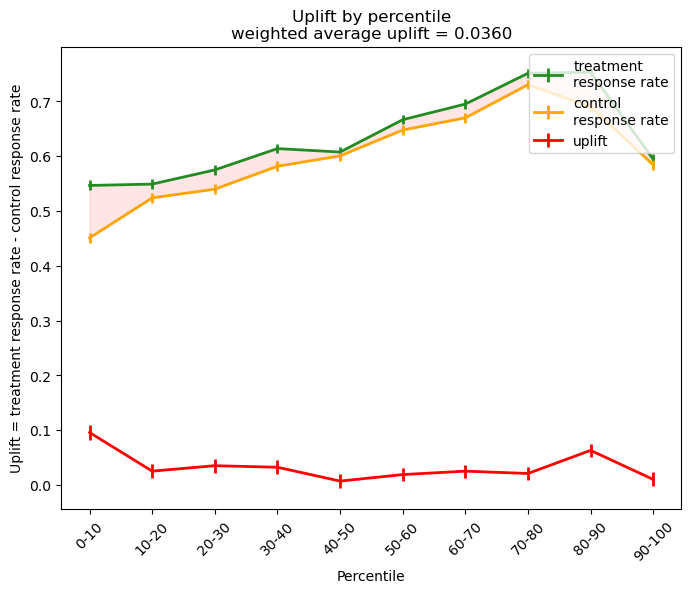

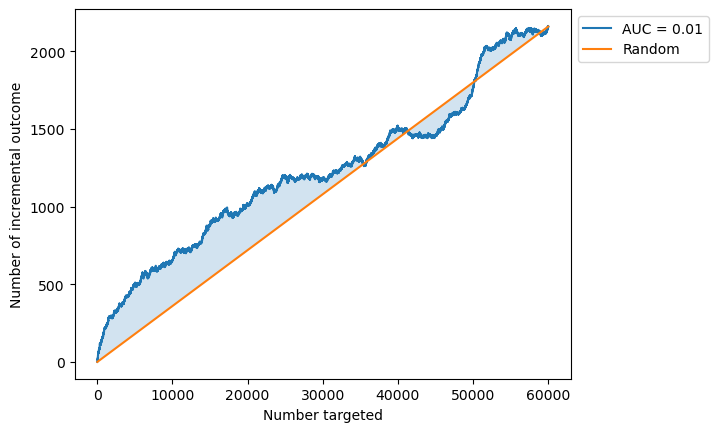

In [11]:
from sklift.models import SoloModel
from sklift.viz import plot_uplift_by_percentile
from sklift.viz import plot_uplift_curve

sm = SoloModel(CatBoostClassifier(**cat_config))
sm.fit(X_train, y_train, treat_train)
sm.predict(X_val)

plot_uplift_by_percentile(y_val, sm.predict(X_val), treat_val, 
                          strategy='overall', kind='line')

plot_uplift_curve(y_val, sm.predict(X_val), treat_val, perfect=False)

sm_fi = pd.DataFrame({
    'feature_name': sm.estimator.feature_names_,
    'feature_score': sm.estimator.feature_importances_
}).sort_values('feature_score', ascending=False).reset_index(drop=True)

sm_fi

## 3.2. T-Learner (Two models approach)

<p align="center" width="500">
    <img src="images/TwoModels.webp" alt="Two Models" width="500"/>
</p>

Let's write it from scratch!

In [12]:
class T_Learner(BaseEstimator):
    def __init__(self, clf):
        self.clf_c = clf.copy()
        self.clf_t = clf.copy()
        self.trained = False
        self.have_predictions = False
        self.treatment_proba = None
        self.control_proba = None
        self.uplift = None
        
    def fit(self, X_train, W_train, Y_train):
        assert len(X_train) == len(W_train) == len(Y_train), "Input data shoud has the same size!"
        mask_c = W_train == 0
        self.clf_c.fit(X_train[mask_c], Y_train[mask_c])
        train = pd.concat([X_train[~mask_c], pd.Series(self.clf_c.predict_proba(X_train[~mask_c])[:, 1], name="probas_c", index=X_train[~mask_c].index)], axis=1)
        self.clf_t.fit(train, Y_train[~mask_c])
        self.trained = True
        
    def predict(self, X_test, W_test):
        assert len(X_test) == len(W_test), "Input data shoud has the same size!"
        assert self.trained, "Model is not trained yet!" 
        X_treatment = pd.concat([X_test, pd.Series(self.clf_c.predict_proba(X_test)[:, 1], name="probas_c", index=X_test.index)], axis=1)
        X_control = X_test
        self.treatment_proba = self.clf_t.predict_proba(X_treatment)[:, 1]
        self.control_proba = self.clf_c.predict_proba(X_control)[:, 1]
        self.uplift = self.treatment_proba - self.control_proba
        self.have_predictions = True
        return self.uplift
    
    def plot_uplift(self, W_test, Y_test, split_size = 10):
        assert len(self.uplift) == len(Y_test) == len(W_test), f"Input data shoud has the same size as self.uplift = {len(self.uplift)}!"
        indices = np.array_split(np.argsort(self.uplift)[::-1], split_size)
        percentiles_str = [f"{i * split_size:.0f}-{(i + 1) * split_size:.0f}" for i in range(split_size)]
        treat_response = []
        control_response = []
        uplift = []
        for inds in indices:
            mask_treat = W_test.iloc[inds] == 1
            treat_response.append(np.mean(Y_test.iloc[inds][mask_treat]))
            control_response.append(np.mean(Y_test.iloc[inds][~mask_treat]))
            uplift.append(np.mean(Y_test.iloc[inds][mask_treat]) - np.mean(Y_test.iloc[inds][~mask_treat]))
        
        #plt.figure(figsize=(8, 6))
        plt.title(f"Uplift by percentile\n Avg uplift={np.array(uplift).mean():.3f}")
        plt.plot(treat_response, "-+", color="blue", label="Treatment response rate")
        plt.plot(control_response, "-+", color="green", label="Control response rate")
        plt.plot(uplift, "-+", color="red", label="Uplift")
        plt.plot(np.zeros(split_size), color="grey")
        plt.xticks(ticks=range(10),labels=percentiles_str, rotation=45)
        plt.xlabel("Percentile")
        plt.legend()

,feature_name,feature_score
0,probas_c,29.256956
1,first_redeem_time,21.726805
2,transaction_amount,14.113779
3,age,6.201779
4,first_issue_time,5.989696
5,avg_transaction,4.996881
6,ragular_points_spent_to_total,4.678586
7,transaction_sum,4.597457
8,express_points_spent_to_total,2.833342
9,regular_points_spent_sum,2.365584


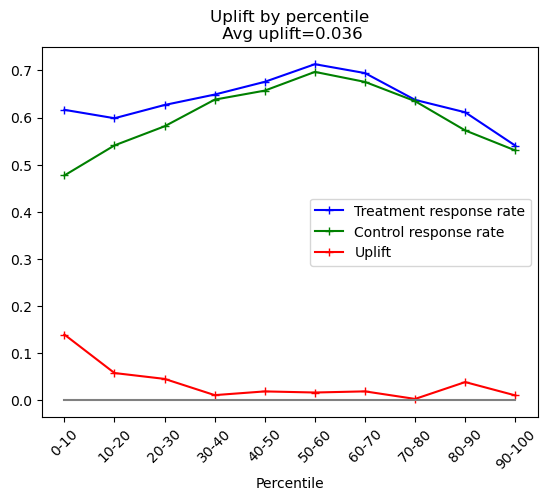

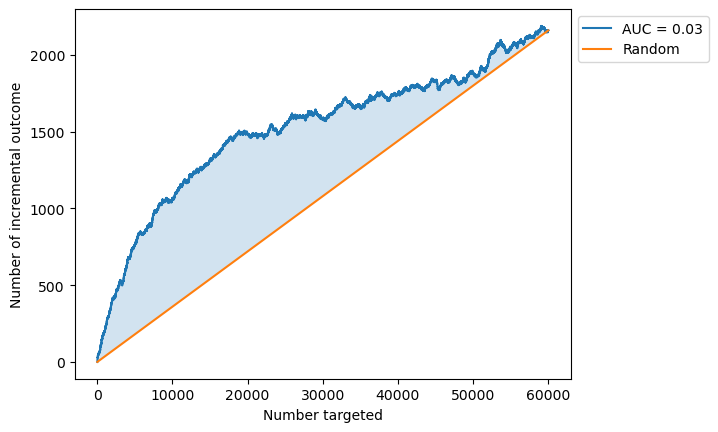

In [13]:
from catboost import CatBoostClassifier

cat_config = {"iterations": 100, "thread_count": 2, "random_state": 42, "silent": True}

s_learner_model = T_Learner(CatBoostClassifier(**cat_config))
s_learner_model.fit(X_train, treat_train, y_train)

uplift = s_learner_model.predict(X_val, treat_val)

s_learner_model.plot_uplift(treat_val, y_val)

plot_uplift_curve(y_val, uplift, treat_val, perfect=False)

feature_importance = pd.DataFrame({
    'feature_name': s_learner_model.clf_t.feature_names_,
    'feature_score': s_learner_model.clf_t.feature_importances_
}).sort_values('feature_score', ascending=False).reset_index(drop=True)

feature_importance

,feature_name,feature_score
0,transaction_amount,32.442576
1,first_redeem_time,30.637877
2,first_issue_time,7.801211
3,age,6.631254
4,avg_transaction,5.437274
5,transaction_sum,4.708742
6,regular_points_spent_sum,3.681684
7,ragular_points_spent_to_total,3.341713
8,express_points_spent_sum,1.956949
9,express_points_spent_to_total,1.578995


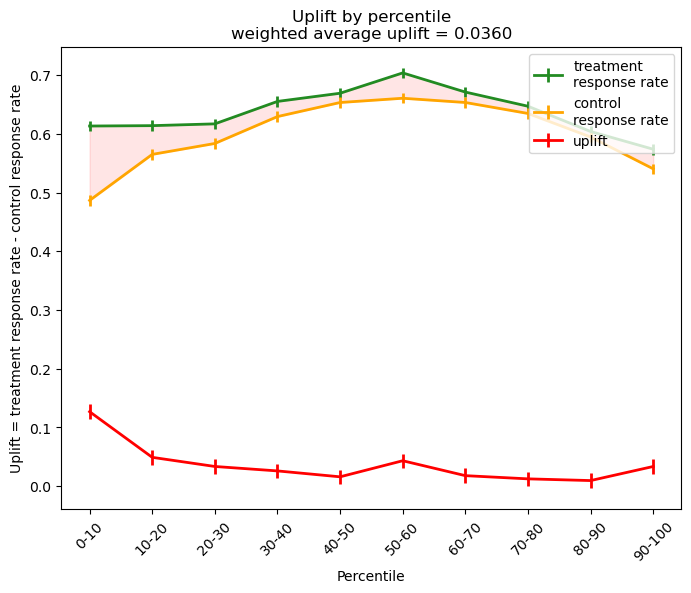

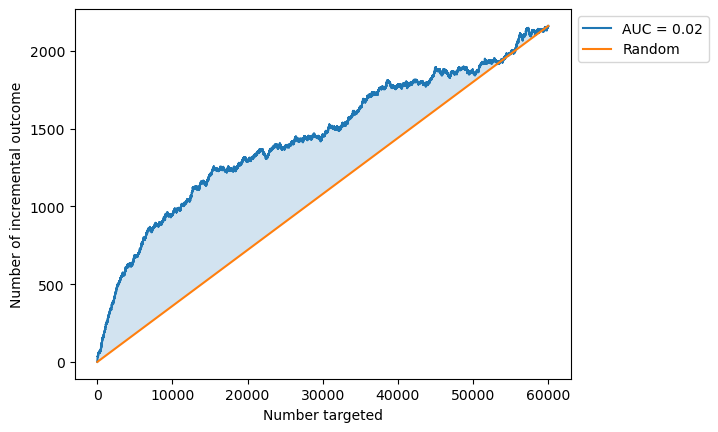

In [14]:
from sklift.models import TwoModels
from sklift.viz import plot_uplift_by_percentile
from sklift.viz import plot_uplift_curve

sm = TwoModels(CatBoostClassifier(**cat_config), CatBoostClassifier(**cat_config))
sm.fit(X_train, y_train, treat_train)
sm.predict(X_val)

plot_uplift_by_percentile(y_val, sm.predict(X_val), treat_val, 
                          strategy='overall', kind='line')

plot_uplift_curve(y_val, sm.predict(X_val), treat_val, perfect=False)

sm_fi = pd.DataFrame({
    'feature_name': sm.estimator_trmnt.feature_names_,
    'feature_score': sm.estimator_trmnt.feature_importances_
}).sort_values('feature_score', ascending=False).reset_index(drop=True)

sm_fi

## 3.3. X-Learner

<p align="center" width="500">
    <img src="images/Xlearner_1.png" alt="X-Learner" width="500"/>
</p>
<p align="center" width="500">
    <img src="images/Xlearner_2.png" alt="X-Learner" width="500"/>
</p>
<p align="center" width="500">
    <img src="images/Xlearner_3.png" alt="X-Learner" width="500"/>
</p>
<p align="center" width="500">
    <img src="images/Xlearner_4.png" alt="X-Learner" width="500"/>
</p>

In [15]:
mask_c = treat_train == 0
np.ones_like(y_train[~mask_c]) - y_train[~mask_c]

client_id
5d9ce7d20a    0
2777619890    1
fe98aa7dc2    0
ede9daaeef    0
1441a5e4c0    0
             ..
affbb7cec7    0
460139e5bb    1
8d1b9968d6    0
bc3a1cca29    0
9c37a8b4cb    1
Name: target, Length: 69845, dtype: int64

Let's write it from scratch!

In [24]:
class X_Learner(BaseEstimator):
    def __init__(self, clf):
        self.clf_c = clf.copy()
        self.clf_t = clf.copy()
        self.trained = False
        self.have_predictions = False
        self.treatment_proba = None
        self.control_proba = None
        self.uplift = None
        
    def fit(self, X_train, W_train, Y_train):
        assert len(X_train) == len(W_train) == len(Y_train), "Input data shoud has the same size!"
        mask_c = W_train == 0
        self.clf_c.fit(X_train[mask_c], Y_train[mask_c])
        self.clf_t.fit(X_train[~mask_c], Y_train[~mask_c])
        D_t = Y_train[~mask_c] - self.clf_c.predict(X_train[~mask_c])
        D_c = self.clf_t.predict(X_train[mask_c]) - Y_train[mask_c]
        self.clf_t.fit(X_train[~mask_c], D_t)
        self.clf_c.fit(X_train[mask_c], D_c)
        self.trained = True
        
    def predict(self, X_test, W_test, g=1):
        assert len(X_test) == len(W_test), "Input data shoud has the same size!"
        assert self.trained, "Model is not trained yet!" 
        X_treatment = X_test
        X_control = X_test
        self.treatment_proba = self.clf_t.predict_proba(X_treatment)[:, 1]
        self.control_proba = self.clf_c.predict_proba(X_control)[:, 1]
        self.uplift = g * self.treatment_proba - (1 - g) * self.control_proba
        self.have_predictions = True
        return self.uplift
    
    def plot_uplift(self, W_test, Y_test, split_size = 10):
        assert len(self.uplift) == len(Y_test) == len(W_test), f"Input data shoud has the same size as self.uplift = {len(self.uplift)}!"
        indices = np.array_split(np.argsort(self.uplift)[::-1], split_size)
        percentiles_str = [f"{i * split_size:.0f}-{(i + 1) * split_size:.0f}" for i in range(split_size)]
        treat_response = []
        control_response = []
        uplift = []
        for inds in indices:
            mask_treat = W_test.iloc[inds] == 1
            treat_response.append(np.mean(Y_test.iloc[inds][mask_treat]))
            control_response.append(np.mean(Y_test.iloc[inds][~mask_treat]))
            uplift.append(np.mean(Y_test.iloc[inds][mask_treat]) - np.mean(Y_test.iloc[inds][~mask_treat]))
        
        #plt.figure(figsize=(8, 6))
        plt.title(f"Uplift by percentile\n Avg uplift={np.array(uplift).mean():.3f}")
        plt.plot(treat_response, "-+", color="blue", label="Treatment response rate")
        plt.plot(control_response, "-+", color="green", label="Control response rate")
        plt.plot(uplift, "-+", color="red", label="Uplift")
        plt.plot(np.zeros(split_size), color="grey")
        plt.xticks(ticks=range(10),labels=percentiles_str, rotation=45)
        plt.xlabel("Percentile")
        plt.legend()

,feature_name,feature_score
0,transaction_amount,48.526573
1,first_redeem_time,11.944706
2,first_issue_time,10.434706
3,age,6.541468
4,avg_transaction,5.039033
5,transaction_sum,4.934149
6,ragular_points_spent_to_total,4.336752
7,regular_points_spent_sum,2.857161
8,express_points_spent_to_total,1.937237
9,express_points_spent_sum,1.287405


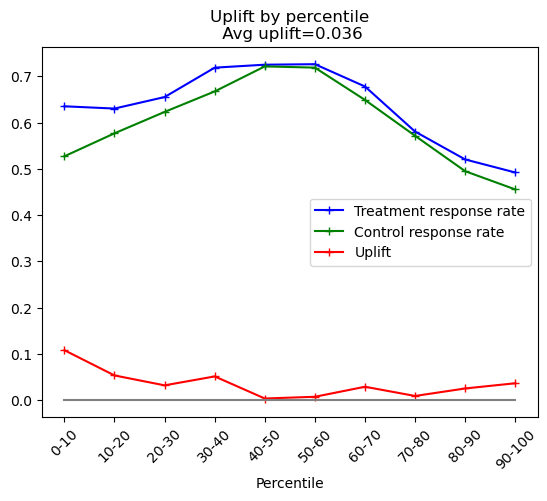

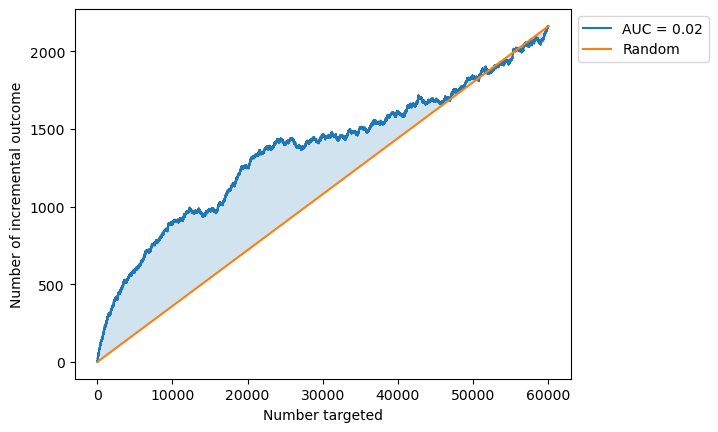

In [27]:
from catboost import CatBoostClassifier

cat_config = {"iterations": 100, "thread_count": 2, "random_state": 42, "silent": True}

s_learner_model = X_Learner(CatBoostClassifier(**cat_config))
s_learner_model.fit(X_train, treat_train, y_train)

uplift = s_learner_model.predict(X_val, treat_val, g=1/2)

s_learner_model.plot_uplift(treat_val, y_val)

plot_uplift_curve(y_val, uplift, treat_val, perfect=False)

feature_importance = pd.DataFrame({
    'feature_name': s_learner_model.clf_t.feature_names_,
    'feature_score': s_learner_model.clf_t.feature_importances_
}).sort_values('feature_score', ascending=False).reset_index(drop=True)

feature_importance

## 2.4 Class Transformation approaсh

,feature_name,feature_score
0,first_redeem_time,27.575400
1,first_issue_time,11.888853
2,age,10.897741
3,avg_transaction,9.292946
4,ragular_points_spent_to_total,8.200407
5,transaction_sum,7.723764
6,transaction_amount,6.785965
7,regular_points_spent_sum,6.357896
8,express_points_spent_to_total,4.557949
9,express_points_spent_sum,3.332883


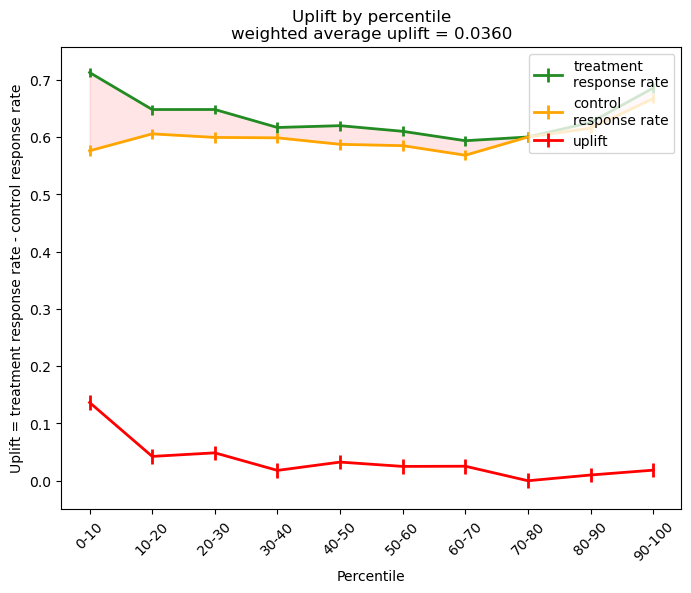

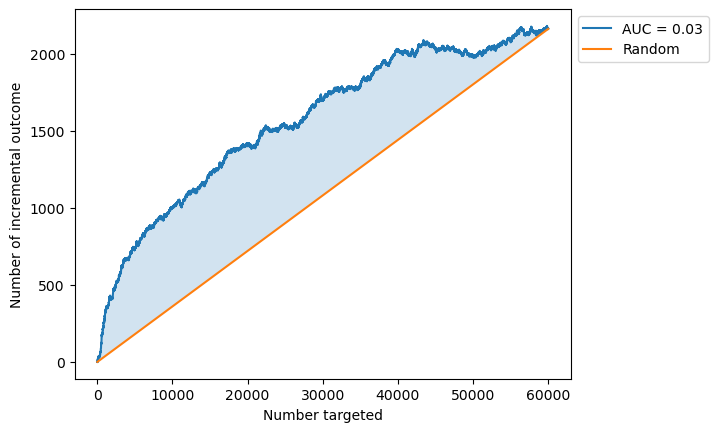

In [28]:
from sklift.models import ClassTransformation
from sklift.viz import plot_uplift_by_percentile
from sklift.viz import plot_uplift_curve

sm = ClassTransformation(CatBoostClassifier(**cat_config))
sm.fit(X_train, y_train, treat_train)
sm.predict(X_val)

plot_uplift_by_percentile(y_val, sm.predict(X_val), treat_val, 
                          strategy='overall', kind='line')

plot_uplift_curve(y_val, sm.predict(X_val), treat_val, perfect=False)

sm_fi = pd.DataFrame({
    'feature_name': sm.estimator.feature_names_,
    'feature_score': sm.estimator.feature_importances_
}).sort_values('feature_score', ascending=False).reset_index(drop=True)

sm_fi